In [1]:
import sys
sys.path.append("../src")

from chimeric_tools.Simulation import COVID
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.lines import Line2D

In [2]:
data = COVID().data

In [3]:
import sys
import numpy as np
import pandas as pd

from epiweeks import Week
   
unique_dates = data.date.unique()

fromDate2EW = { "date":[], "start_date":[], "end_date":[], "EW":[] }
for date in unique_dates:
    fromDate2EW["date"].append(date)

    dt = pd.to_datetime(date)
    week = Week.fromdate(dt)

    startdate = week.startdate()
    fromDate2EW["start_date"].append( startdate )

    enddate = week.enddate()
    fromDate2EW["end_date"].append( enddate )

    fromDate2EW["EW"].append( week.cdcformat() )
fromDate2EW = pd.DataFrame(fromDate2EW)

data = data.merge(fromDate2EW, on = ["date"])

def aggregate(x):
    cases =  x.value.sum()

    return pd.Series({"cases":cases})
    
weekly_date = data.groupby( ["location", "location_name", "start_date", "end_date", "EW"]).apply(aggregate)
weekly_date = weekly_date.reset_index()

In [4]:
data = weekly_date

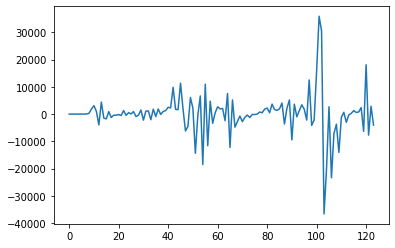

In [5]:
y = np.array(data["cases"][1:]).reshape(-1,)
mod = sm.tsa.statespace.SARIMAX(data["cases"], order=(2,1,0))
res = mod.fit(disp=0)
residuals = res.resid
residuals.plot()
pred = res.predict()


In [9]:
def NBB(x, block_size):
    """
    Non-overlapping Block Bootstrap
    """
    n = len(x)
    # check length of x 
    overflow_len = n % block_size
    if overflow_len != 0:
        x = x[:-overflow_len]
    n_blocks = int(n/block_size)
    blocks = np.array_split(x, n_blocks)
    d = []
    # randomly select n_blocks blocks from the list of blocks with replacement
    for i in range(n_blocks+1):
        d.append(blocks[np.random.randint(0, n_blocks)])
    [x for xs in d for x in xs]
    if overflow_len != 0:
        return [x for xs in d for x in xs][:-(block_size - overflow_len)]
    return [x for xs in d for x in xs]


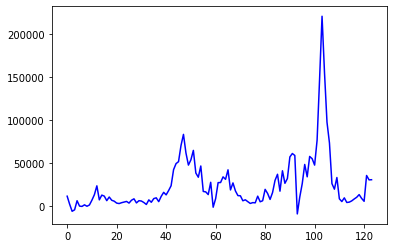

In [11]:
d = NBB(residuals, 5)
new =  pred + d
plt.plot(new, color='blue')

In [14]:
pred[:-1]

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
118    10857.289720
119    15159.401110
120     3191.834721
121    35035.343481
122    26762.795661
Name: predicted_mean, Length: 123, dtype: float64

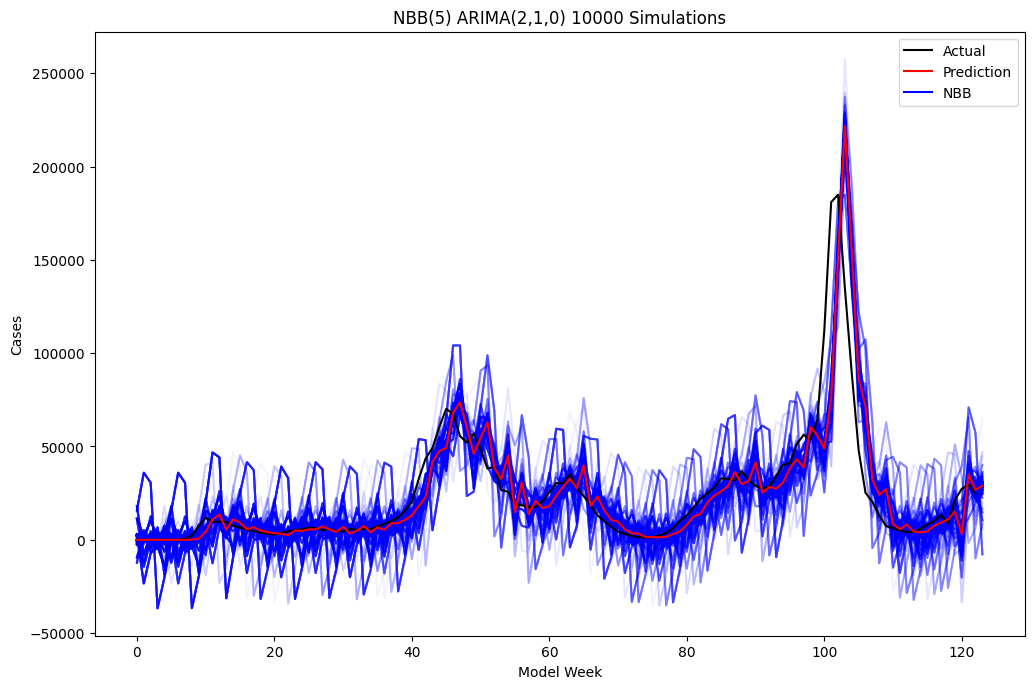

In [46]:
fig = plt.figure(figsize=(12,8), dpi=100)
for i in range(0,1000):
    d = NBB(residuals, 5)
    diff =  -(len(d)-(len(pred)))
    if diff == 0:
        new =  pred + d
    else:
        new = pred + d[:-(len(d)-(len(pred)))]
    plt.plot(new, color='blue', alpha=0.05)
plt.plot(y, color='black')
plt.plot(pred, color='red')
colors = ['black', 'red', 'blue']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Actual', 'Prediction', 'NBB']
plt.legend(lines, labels)
plt.xlabel("Model Week")
plt.ylabel("Cases")
plt.title("NBB(5) ARIMA(2,1,0) 10000 Simulations")
plt.savefig('NBB(5) ARIMA(2,1,0) 1000 Simulations.png', facecolor='white', transparent=False)